# Introduction

I'll be use transfer learning on a pre-trained CNN (MobileNet) to build an Alpaca/Not Alpaca classifier!

<img src="images/alpaca.png" style="width:300px;height:220px;">

A pre-trained model is a network that's already been trained on a large dataset and saved, which allows  to use it to customize our own model cheaply and efficiently. The one I'll be using, MobileNetV2, which was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.


In [1]:
import numpy as np
import pandas as pd
import cv2
from skimage import io
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


### Create the Dataset and Split it into Training and Validation Sets

When training and evaluating deep learning models in Keras, generating a dataset from image files stored on disk is simple and fast. 
Call `image_data_set_from_directory()` to read from the directory and create both training and validation datasets. 

when Iam specifying a validation split, I'll also need to specify the subset for each portion. Just set the training set to `subset='training'` and the validation set to `subset='validation'`.


In [2]:
train_dataset = image_dataset_from_directory(
    directory = '/content/drive/MyDrive/dataset',
    batch_size = 32,
    image_size = (160, 160),
    validation_split = 0.2,
    subset = "training",
    seed = 42
)

validation_dataset = image_dataset_from_directory(
    directory = '/content/drive/MyDrive/dataset',
    batch_size = 32,
    image_size = (160, 160),
    validation_split = 0.2,
    subset = 'validation',
    seed = 42
)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


### Now let's take a look at some of the images from the training set:

note : Images are stored in a tensorlow dataset (as a set of numpy arrays) so we have to use .numpy().astype("uint8") to show it as a photo

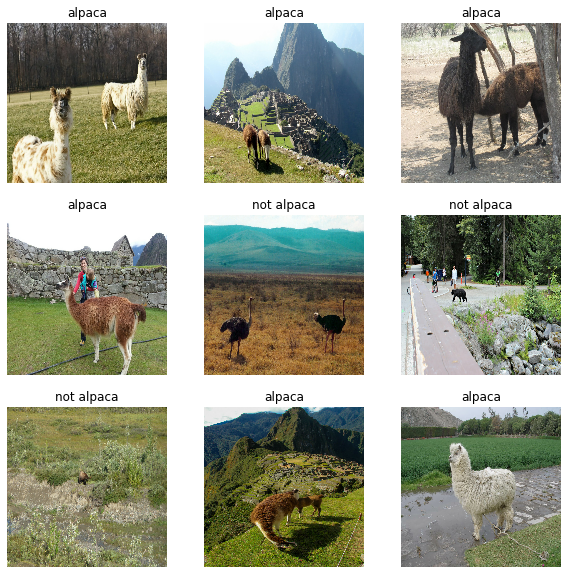

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))

for i in range(9):
  for images, labels in train_dataset.take(1):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Preprocessing and Augmenting the Training Data


Using prefetch() prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from our input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

We can set the number of elements to prefetch manually, or we can use tf.data.experimental.AUTOTUNE to choose the parameters automatically. Autotune prompts tf.data to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations.


In [4]:
Autotune = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size = Autotune)

## Data Augmentation

Implement a function for data augmentation. Use a `Sequential` keras model composed of 2 layers:
* `RandomFlip('horizontal')`
* `RandomRotation(0.2)`

In [5]:
def data_augmenter():

  data_aug = Sequential()
  data_aug.add(RandomFlip('horizontal'))
  data_aug.add(RandomRotation(0.2))

  return data_aug


### Take a look at how an image from the training set has been augmented with simple transformations:

Note : Expand Dim operation is useful if you want to add a batch dimension to a single element. For example, if you have a single image of shape [height, width, channels], you can make it a batch of 1 image with expand_dims(image, 0), which will make the shape [1, height, width, channels].

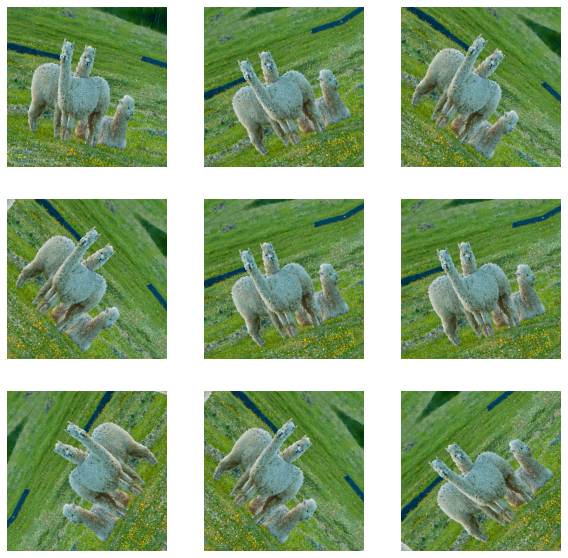

In [6]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")

# USing MobileNetV2

MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and  depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps: 

1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution, or: **Shape of the depthwise convolution X Number of filters.**

<img src="images/mobilenetv2.png" style="width:650px;height:450px;">
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>MobileNetV2 Architecture</b> <br> This diagram was inspired by the original seen <a href="https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a%20significant%20improvement,object%20detection%20and%20semantic%20segmentation.">here</a>.</center></caption>

Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information. 

The shortcut connections, which are similar to the ones in traditional residual networks, serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers. 

In [7]:
base_model = MobileNetV2(
    input_shape = (160, 160, 3),
    include_top = True,
    weights='imagenet'
)

14548992/14536120 [==============================] - 0s 0us/step


In [8]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 Layer Freezing with the Functional API

<img src="images/snowalpaca.png" style="width:400px;height:250px;">

In the next sections, I'll use a pretrained model to modify the classifier task so that it's able to recognize alpacas. We can achieve this in three steps: 

1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
    * As mentioned before, a single neuron is enough to solve a binary classification problem.
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

In [26]:
def alpaca_model():
   
    input_shape = (160, 160, 3)
    
    base_model =MobileNetV2(input_shape=input_shape,
                            include_top=False, 
                            weights='imagenet') 
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = Input(input_shape)
    
    # apply data augmentation to the inputs
    x = data_augmenter()(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(rate=0.2)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = Dense(1)
    outputs = prediction_layer(x)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model



In [27]:
a_model = alpaca_model()
a_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [28]:
from tensorflow.keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

a_model.compile(
    optimizer = Adam(lr = 0.001),
    loss = BinaryCrossentropy( from_logits = True),
    metrics=['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [41]:
initial_epochs = 50

In [29]:
history = a_model.fit(train_dataset, validation_data=validation_dataset, epochs=20)

Epoch 1/20
9/9 [==============================] - 6s 214ms/step - loss: 0.7574 - accuracy: 0.5649 - val_loss: 0.5270 - val_accuracy: 0.7538
Epoch 2/20
9/9 [==============================] - 2s 90ms/step - loss: 0.5749 - accuracy: 0.6985 - val_loss: 0.4505 - val_accuracy: 0.7385
Epoch 3/20
9/9 [==============================] - 2s 91ms/step - loss: 0.4700 - accuracy: 0.7557 - val_loss: 0.3614 - val_accuracy: 0.8462
Epoch 4/20
9/9 [==============================] - 2s 92ms/step - loss: 0.4034 - accuracy: 0.8053 - val_loss: 0.3278 - val_accuracy: 0.8615
Epoch 5/20
9/9 [==============================] - 2s 89ms/step - loss: 0.4356 - accuracy: 0.7672 - val_loss: 0.2940 - val_accuracy: 0.9077
Epoch 6/20
9/9 [==============================] - 2s 90ms/step - loss: 0.3705 - accuracy: 0.8435 - val_loss: 0.2645 - val_accuracy: 0.9077
Epoch 7/20
9/9 [==============================] - 2s 94ms/step - loss: 0.3743 - accuracy: 0.7824 - val_loss: 0.2732 - val_accuracy: 0.8923
Epoch 8/20
9/9 [==========

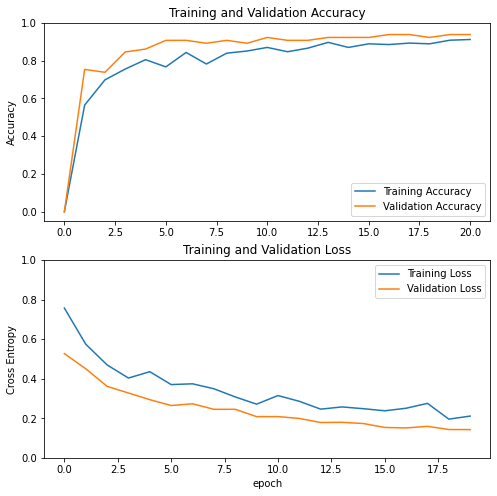

In [31]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine-Tuning the Model

In transfer learning, the way we fine-tuning the model is by unfreezing the layers at the end of the network, and then re-training your model on the final layers with a very low learning rate. Adapting the learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

To achieve this:- 
* Just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

* First, unfreeze the base model by setting `base_model.trainable=True`, set a layer to fine-tune from, then re-freeze all the layers before it. Run it again for another few epochs, and see if your accuracy improved!

In [33]:
base_model = a_model.layers[4]
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))


Number of layers in the base model:  154


In [34]:
for layer in base_model.layers[0:120]:
    layer.trainable = True

base_model.compile(
    optimizer = Adam(lr = 0.001),
    loss = BinaryCrossentropy( from_logits = True),
    metrics=['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [42]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

In [38]:
history_fine =a_model.fit(train_dataset,
                         epochs=50,
                         validation_data=validation_dataset)

Epoch 1/50
9/9 [==============================] - 2s 93ms/step - loss: 0.1541 - accuracy: 0.9542 - val_loss: 0.1060 - val_accuracy: 0.9692
Epoch 2/50
9/9 [==============================] - 2s 92ms/step - loss: 0.1962 - accuracy: 0.9046 - val_loss: 0.1126 - val_accuracy: 0.9385
Epoch 3/50
9/9 [==============================] - 2s 88ms/step - loss: 0.1685 - accuracy: 0.9237 - val_loss: 0.1047 - val_accuracy: 0.9692
Epoch 4/50
9/9 [==============================] - 2s 92ms/step - loss: 0.1391 - accuracy: 0.9618 - val_loss: 0.1039 - val_accuracy: 0.9692
Epoch 5/50
9/9 [==============================] - 2s 92ms/step - loss: 0.1936 - accuracy: 0.9275 - val_loss: 0.1096 - val_accuracy: 0.9538
Epoch 6/50
9/9 [==============================] - 2s 92ms/step - loss: 0.1909 - accuracy: 0.9046 - val_loss: 0.1022 - val_accuracy: 0.9692
Epoch 7/50
9/9 [==============================] - 2s 89ms/step - loss: 0.1463 - accuracy: 0.9542 - val_loss: 0.0996 - val_accuracy: 0.9692
Epoch 8/50
9/9 [===========

In [39]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

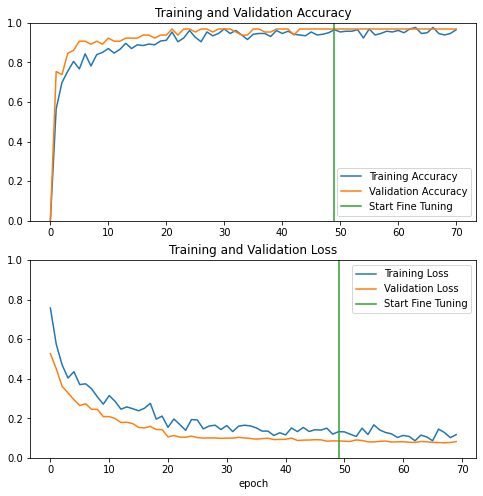

In [43]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()